# Modeling for garbage classification

## Model VGG16

For the garbage classification, we choose to classify the garbage with the VGG16 model which is a famous CNN model used for image classification

In [1]:
%load_ext autoreload
%autoreload 2

### Data

In [2]:
%pwd

'/Users/walkyz/code/kirianpg/waste_sorter_smart_bin/notebooks'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [67]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

def load_flowers_data():
    data_path = '../data/raw_data/kaggle_data/Garbage classification/Garbage classification'
    classes = {
        'trash': 0,
        'glass': 1,
        'paper': 2,
        'cardboard': 3,
        'plastic': 4,
        'metal': 5}
    
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((224, 224))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [5]:
# CALL load_flowers_data WITH YOUR PREFERRED METHOD HERE
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data()

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 373.56it/s]


In [6]:
X_train

array([[[[214, 189, 159],
         [217, 192, 162],
         [222, 197, 167],
         ...,
         [ 98,  87,  75],
         [ 85,  73,  61],
         [ 61,  49,  37]],

        [[216, 191, 161],
         [217, 192, 162],
         [216, 191, 161],
         ...,
         [ 99,  87,  75],
         [ 96,  83,  71],
         [ 69,  57,  45]],

        [[216, 191, 161],
         [219, 194, 164],
         [215, 190, 160],
         ...,
         [103,  92,  80],
         [102,  90,  78],
         [ 84,  72,  60]],

        ...,

        [[208, 182, 155],
         [211, 185, 158],
         [215, 189, 162],
         ...,
         [126, 106,  81],
         [123, 103,  78],
         [120, 100,  75]],

        [[207, 181, 154],
         [215, 189, 162],
         [221, 195, 168],
         ...,
         [127, 107,  82],
         [125, 105,  80],
         [121, 101,  76]],

        [[207, 181, 154],
         [215, 189, 162],
         [221, 195, 168],
         ...,
         [127, 107,  82],
        

### Initialize the model

In [45]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.models import Sequential

In [8]:
def load_model_VGG16():

    model = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
    )

    return model

In [9]:
model_VGG16 = load_model_VGG16()

In [10]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Lock the layers of the VGG16 model

We need to preserve the training of the initial model

In [11]:
def set_nontrainable_layers(model):

    model.trainable = False
    
    return model

In [12]:
model_VGG16_snl = set_nontrainable_layers(model_VGG16)

In [13]:
model_VGG16_snl.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Transfer learning + regularizers

In [46]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top, + regularizers'''
    reg = regularizers.l1_l2(l2=0.005)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(512, activation='relu', kernel_regularizer=reg)
    dropout_layer = layers.Dropout(0.5)
    prediction_layer = layers.Dense(6, activation='softmax')

    final_model = Sequential([
        model,
        flattening_layer,
        dense_layer,
        dropout_layer,
        prediction_layer
    ]) 
    
    return final_model

In [47]:
customized_VGG16 = add_last_layers(model_VGG16_snl)

In [48]:
customized_VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 27,563,334
Trainable params: 12,848,646
Non-trainable params: 14,714,688
_________________________________________________________________


### Compiling the model

In [49]:
def build_model():
  adam = optimizers.Adam(learning_rate=1e-4)
  customized_VGG16.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
  )

  return customized_VGG16

In [50]:
builded_VGG16 = build_model()

In [51]:
builded_VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 27,563,334
Trainable params: 12,848,646
Non-trainable params: 14,714,688
_________________________________________________________________


### Process the data

In [52]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [53]:
X_train_preproc = preprocess_input(X_train)
X_test_preproc = preprocess_input(X_test)
X_val_preproc = preprocess_input(X_val)

### Fit the model

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [24]:
history = builded_VGG16.fit(
    X_train_preproc, y_train,
    batch_size = 64,
    epochs = 5,
    verbose=1,
    callbacks=[es],
    validation_data=(X_val_preproc, y_val)
)

Epoch 1/5


2024-03-12 11:43:47.718905: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


17/17 [==============================] - 136s 8s/step - loss: 7.4793 - accuracy: 0.4740 - val_loss: 3.2216 - val_accuracy: 0.6972
Epoch 2/5
17/17 [==============================] - 124s 7s/step - loss: 1.0882 - accuracy: 0.8603 - val_loss: 2.7792 - val_accuracy: 0.7248
Epoch 3/5
17/17 [==============================] - 128s 8s/step - loss: 0.4760 - accuracy: 0.9171 - val_loss: 2.4080 - val_accuracy: 0.7645
Epoch 4/5
17/17 [==============================] - 136s 8s/step - loss: 0.1860 - accuracy: 0.9615 - val_loss: 2.2896 - val_accuracy: 0.7737
Epoch 5/5
17/17 [==============================] - 147s 9s/step - loss: 0.0686 - accuracy: 0.9827 - val_loss: 2.2108 - val_accuracy: 0.7706


In [58]:
history = builded_VGG16.fit(
    X_train_preproc, y_train,
    batch_size = 64,
    epochs = 15,
    verbose=1,
    callbacks=[es],
    validation_data=(X_val_preproc, y_val)
)

Epoch 1/15
17/17 [==============================] - 129s 8s/step - loss: 466.9058 - accuracy: 0.9711 - val_loss: 424.1736 - val_accuracy: 0.7676
Epoch 2/15
17/17 [==============================] - 120s 7s/step - loss: 389.7009 - accuracy: 0.9750 - val_loss: 352.0122 - val_accuracy: 0.7737
Epoch 3/15
17/17 [==============================] - 119s 7s/step - loss: 322.2397 - accuracy: 0.9682 - val_loss: 290.2584 - val_accuracy: 0.7798
Epoch 4/15
17/17 [==============================] - 120s 7s/step - loss: 265.2240 - accuracy: 0.9740 - val_loss: 239.3058 - val_accuracy: 0.7798
Epoch 5/15
17/17 [==============================] - 119s 7s/step - loss: 218.9799 - accuracy: 0.9778 - val_loss: 198.2123 - val_accuracy: 0.7951
Epoch 6/15
17/17 [==============================] - 121s 7s/step - loss: 181.3257 - accuracy: 0.9701 - val_loss: 164.7192 - val_accuracy: 0.7615
Epoch 7/15
17/17 [==============================] - 119s 7s/step - loss: 150.4224 - accuracy: 0.9759 - val_loss: 136.7532 - val_ac

### Learning Curves

In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

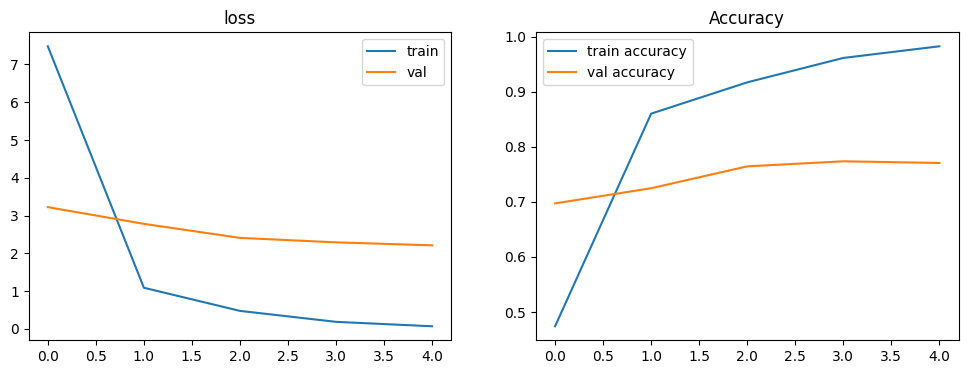

In [27]:
plot_history(history)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

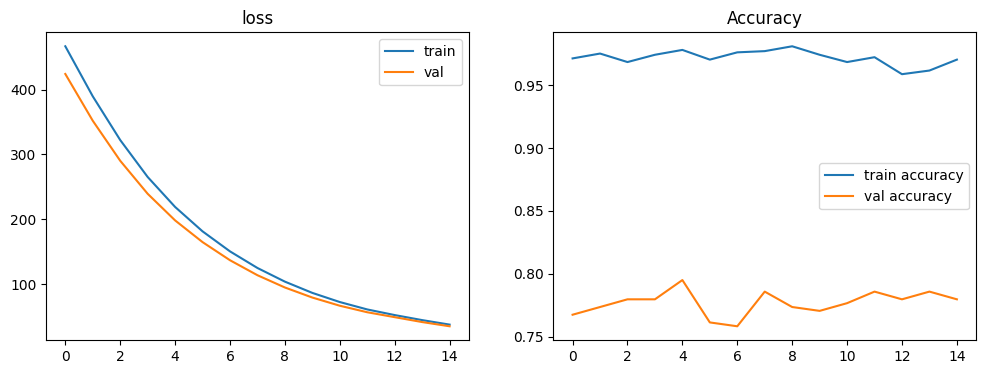

In [59]:
plot_history(history)

### Evaluate the model

In [28]:
builded_VGG16.evaluate(X_test_preproc, y_test)

9/9 [==============================] - 29s 3s/step - loss: 2.0226 - accuracy: 0.7537


[2.0225772857666016, 0.7536764740943909]

In [60]:
builded_VGG16.evaluate(X_test_preproc, y_test)

9/9 [==============================] - 25s 3s/step - loss: 34.7872 - accuracy: 0.7868


[34.78724670410156, 0.7867646813392639]

### Make predictions

In [61]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

#### Trash predicting

1/1 [==============================] - 0s 170ms/step

 Prediction :
trash : 0.57
glass : 0.43
paper : 0.0
cardboard : 0.0
plastic : 0.0
metal : 0.0


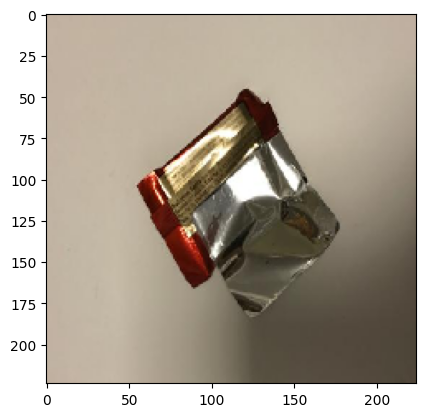

In [66]:
img_path = '../data/raw_data/kaggle_data/Garbage classification/Garbage classification/trash/trash40.jpg'
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = builded_VGG16.predict(x)

classes = ['trash', 'glass', 'paper', 'cardboard', 'plastic', 'metal']

plt.imshow(img)
print('\n Prediction :')
for i in range(6):
    print(f'{classes[i]} : {round(float(predictions[0][i]), 2)}')